In [1]:
import cv2
import pickle
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
%matplotlib inline


from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Input, Embedding, LSTM, Dense, merge, Convolution2D, MaxPooling2D, Reshape, Flatten, Dropout
from keras.optimizers import RMSprop, Adam
from keras import initializations

Using TensorFlow backend.


In [2]:
def my_init(shape, name=None):
    return initializations.normal(shape, scale=0.01, name=name)

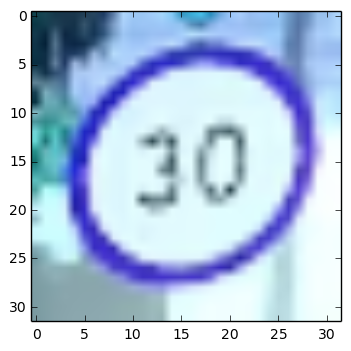

In [3]:
my_image = cv2.imread('im0002.png')
my_image = cv2.resize(my_image, (32,32))
plt.imshow(my_image)
my_data = np.zeros(shape=(1,32,32,3))
my_data[0,:,:,0] = my_image[:,:,2]
my_data[0,:,:,1] = my_image[:,:,1]
my_data[0,:,:,2] = my_image[:,:,0]
my_data = my_data.astype(np.float32)/255
my_data -= 0.5

In [4]:
# Read data
training_file = '/home/autti/Downloads/traffic-signs-data/train_p2.p'
testing_file = '/home/autti/Downloads/traffic-signs-data/test_p2.p'


with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)


X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [5]:
# normalize data
X_train = X_train.astype(np.float32)/255
X_train -= 0.5
X_test = X_test.astype(np.float32)/255
X_test -= 0.5

print(X_train[0,:,:,0])
print("max",np.max(y_train),"min",np.min(y_train))
y_label_train = np.zeros(shape=(y_train.shape[0], np.max(y_train) + 1))
y_label_test = np.zeros(shape=(y_test.shape[0], np.max(y_test) + 1))

for i in range(y_train.shape[0]):
    y_label_train[i, y_train[i]]=1

for i in range(y_test.shape[0]):
    y_label_test[i, y_test[i]]=1

#X_train = X_train[:10]
#y_label = y_label[:10]
#print(y_label[-2:,:])

[[-0.20588234 -0.20980391 -0.17450979 ..., -0.23725489 -0.24509802
  -0.24117646]
 [-0.17843136 -0.1862745  -0.15882352 ..., -0.21372548 -0.20588234
  -0.19019607]
 [-0.19019607 -0.17058823 -0.14313725 ..., -0.21764705 -0.20980391
  -0.19411764]
 ..., 
 [-0.00588235 -0.0372549  -0.07647058 ..., -0.1235294  -0.1117647
  -0.1117647 ]
 [-0.14705881 -0.14313725 -0.1980392  ..., -0.09215686 -0.08039215
  -0.12745097]
 [-0.16666666 -0.13529411 -0.22941175 ..., -0.10392156 -0.11568627
  -0.14705881]]
('max', 42, 'min', 0)


In [6]:
prefix = 'traffic'
model_path ='.model_{0}.h5'.format(prefix) 
sgd_select = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

In [8]:
# input layer
main_input = Input(shape=(32, 32, 3), name='main_input')

color_map = Convolution2D(3, 1, 1, init=my_init, border_mode='same')(main_input)

conv1 = Convolution2D(32, 3, 3, init=my_init, border_mode='same')(color_map)
conv2 = Convolution2D(32, 3, 3, init=my_init, border_mode='same')(conv1)
pool1 = MaxPooling2D(pool_size=(3, 3))(conv2)
drop1 = Dropout(0.5)(pool1)

conv3 = Convolution2D(64, 3, 3, init=my_init, border_mode='same')(drop1)
conv4 = Convolution2D(64, 3, 3, init=my_init, border_mode='same')(conv3)
pool2 = MaxPooling2D(pool_size=(3, 3))(conv4)
drop2 = Dropout(0.5)(pool2)

conv5 = Convolution2D(128, 3, 3, init=my_init, border_mode='same')(drop2)
conv6 = Convolution2D(128, 3, 3, init=my_init, border_mode='same')(conv5)
pool3 = MaxPooling2D(pool_size=(3, 3))(conv6)
drop3 = Dropout(0.5)(pool3)

# flatten layer
flat1 = Flatten()(drop1)
flat2 = Flatten()(drop2)
flat3 = Flatten()(drop3)

# concatenate all vectors
merged1 = merge([flat1, flat2, flat3], name='merge1', mode='concat',concat_axis = 1)

fc1 = Dense(1024)(merged1)
drop4 = Dropout(0.5)(fc1)

fc2 = Dense(1024)(drop4)
drop5 = Dropout(0.5)(fc2)

softmax_layer = Dense(43)(drop5)
main_output = Activation('softmax')(softmax_layer)
print("final", main_output)

('final', <tf.Tensor 'Softmax_1:0' shape=(?, 43) dtype=float32>)


In [8]:
sign_model = Model(input = [main_input], output = [main_output])
sign_model.compile(optimizer = sgd_select, loss = 'categorical_crossentropy', metrics=['accuracy'])
prefix = 'traffic'
model_path ='.model_{0}.h5'.format(prefix)
sign_model.load_weights(model_path)
scores = sign_model.evaluate(X_test, y_label_test)
print("%s: %.2f%%" % (sign_model.metrics_names[1], scores[1]*100))
#print(predictions)

12630/12630 [==============================] - 1s       

In [ ]:
predictions = sign_model.predict(my_data)
print(predictions)
my_pred = np.argmax(predictions) 
print(my_pred)
print(predictions[0, my_pred])

In [ ]:
idx = y_train == my_pred
class_11 = train['features'][idx]
print(class_11.shape)
print(np.sum(idx))
plt.imshow(class_11[110,:,:,:])

In [ ]:
plt.imshow(train['features'][2310,:,:,:])

In [ ]:
for j in range(43):
    plt.figure()
    idy = y_train == j
    class_y = train['features'][idy]
    plt.imshow(class_y[1,:,:,:])

In [ ]:
idy = y_train == 1
class_y = train['features'][idy]
for j in range(200,228):
    plt.figure()
    plt.imshow(class_y[j,:,:,:])